# Оптимизация производства металлургического комбината

***Описание проекта:*** 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая предскажет конечную температуру стали.

***Описание данных:***

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

***План работы над проектом:***

1. Знакомство с данными
2. Предобработка данных
3. Обучение моделей
4. Общий вывод

## Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

from sklearn.metrics import mean_absolute_error


sns.set(rc={'figure.figsize': (15, 10)})
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def start(df):
        df.info()
        print('\n',df.describe())
        display(df.sample(5))
        print('Количество пропусков в таблице:', df.isna().sum().sum(), '\n')
        print(df.isna().sum(), '\n')
        print('Количество дубликатов в таблице:',  df.duplicated().sum())
        #df.hist(figsize=(15, 15));

Данные, которые у нас в распоряжении из разных источников. Будем рассматривать по отдельности каждую таблицу, а пока поместим в отдельные переменные каждый датасет.

In [3]:
data_arc = pd.read_csv('data_arc_new.csv', index_col='key')   
data_bulk = pd.read_csv('data_bulk_new.csv', index_col='key')   
data_bulk_time = pd.read_csv('data_bulk_time_new.csv', index_col='key')   
data_gas = pd.read_csv('data_gas_new.csv', index_col='key')   
data_temp = pd.read_csv('data_temp_new.csv', index_col='key')   
data_wire = pd.read_csv('data_wire_new.csv', index_col='key')   
data_wire_time = pd.read_csv('data_wire_time_new.csv', index_col='key')  

In [4]:
start(data_arc)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14876 entries, 1 to 3241
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Начало нагрева дугой  14876 non-null  object 
 1   Конец нагрева дугой   14876 non-null  object 
 2   Активная мощность     14876 non-null  float64
 3   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), object(2)
memory usage: 581.1+ KB

        Активная мощность  Реактивная мощность
count       14876.000000         14876.000000
mean            0.662752             0.438986
std             0.258885             5.873485
min             0.223120          -715.479924
25%             0.467115             0.337175
50%             0.599587             0.441639
75%             0.830070             0.608201
max             1.463773             1.270284


,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
707,2019-05-31 01:30:39,2019-05-31 01:32:40,1.203783,0.888762
101,2019-05-07 03:22:54,2019-05-07 03:27:22,0.354442,0.244310
1155,2019-06-16 10:38:51,2019-06-16 10:42:11,0.992168,0.813739
2092,2019-07-26 15:41:43,2019-07-26 15:46:45,0.566142,0.397543
390,2019-05-18 13:56:03,2019-05-18 13:58:25,0.780168,0.508563


Количество пропусков в таблице: 0 

Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64 

Количество дубликатов в таблице: 0


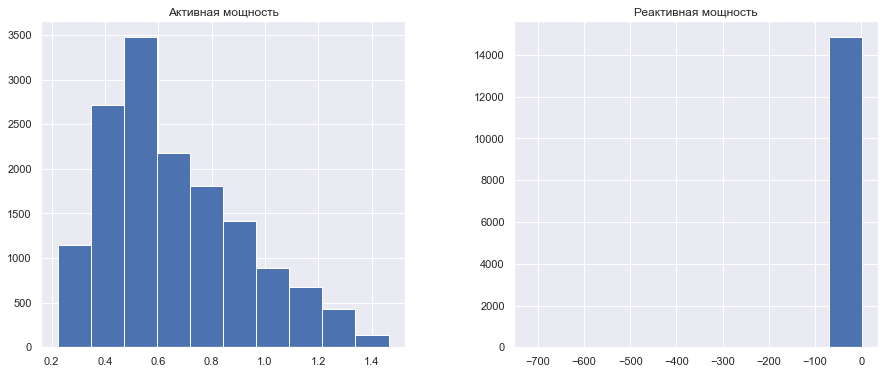

In [5]:
data_arc.hist(figsize=(15, 6));

В таблице `data_arc — данные об электродах`:
- нет пропусков и нет дубликатов;
- в столбцах `Начало нагрева дугой` и `Конец нагрева дугой` должен быть тип данных `не object`. Менять его на `datetime` мы не будем так как использовать эти данные мы не собираемся. Удалим эти столбцы из таблицы до объединения признаков в одну таблицу;
- к `Активная мощность` вопросов нет, а вот аномалии в `Реактивная мощность` мы удалим. Все значения, что `меньше -100`;
- агрегируем данные по партии, ссумировав показатели;
- переименуем столбцы на латиницу и в формат snake_case.

In [6]:
start(data_bulk)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     float64
 5   Bulk 6   576 non-null    float64
 6   Bulk 7   25 non-null     float64
 7   Bulk 8   1 non-null      float64
 8   Bulk 9   19 non-null     float64
 9   Bulk 10  176 non-null    float64
 10  Bulk 11  177 non-null    float64
 11  Bulk 12  2450 non-null   float64
 12  Bulk 13  18 non-null     float64
 13  Bulk 14  2806 non-null   float64
 14  Bulk 15  2248 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB

            Bulk 1      Bulk 2       Bulk 3       Bulk 4      Bulk 5  \
count  252.000000   22.000000  1298.000000  1014.000000   77.000000   
mean    39.242063  253.045455   113.879045   104.394477  107

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1028,NaN,NaN,454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242.0,205.0,NaN,102.0,103.0
2861,NaN,NaN,46.0,NaN,NaN,230.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,154.0,106.0
136,48.0,NaN,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,155.0,205.0
2438,NaN,NaN,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316.0,NaN,184.0,213.0
2960,NaN,NaN,NaN,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,NaN,98.0,104.0


Количество пропусков в таблице: 35776 

Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64 

Количество дубликатов в таблице: 80


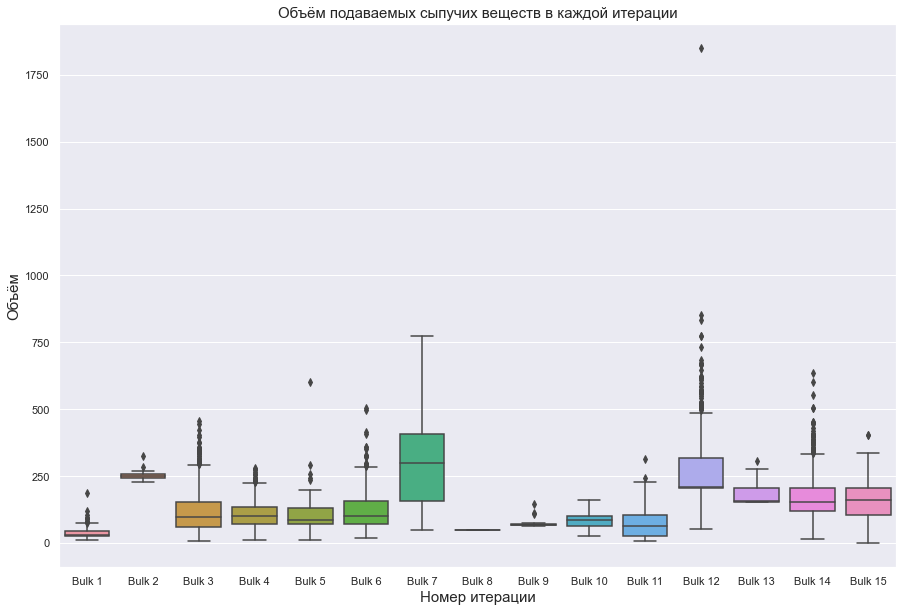

In [7]:
sns.boxplot(data=data_bulk);
plt.title('Объём подаваемых сыпучих веществ в каждой итерации', fontsize=15);
plt.xlabel('Номер итерации', fontsize=15);
plt.ylabel('Объём', fontsize=15);

В таблице `data_bulk — данные о подаче сыпучих материалов (объём)`:
- дубликатов нет, но есть много пропусков;
- заполним все пропуски значением `0 - не добавляли сыпучие материалы в итерации`;
- избавимся от явного выброса в 12 итерации;
- переименуем столбцы в формат snake_case.

Таблицу `data_bulk_time` мы рассматривать не будем, так как при обучении моделей не будем использовать временные данные. Поэтому переходим к рассмотрению `data_gas - данные о продувке сплава газом`.

In [8]:
start(data_gas)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB

              Газ 1
count  3239.000000
mean     11.002062
std       6.220327
min       0.008399
25%       7.043089
50%       9.836267
75%      13.769915
max      77.995040


,Газ 1
key,
128,6.068067
1758,6.817268
77,11.024942
1809,11.486132
775,9.143437


Количество пропусков в таблице: 0 

Газ 1    0
dtype: int64 

Количество дубликатов в таблице: 0


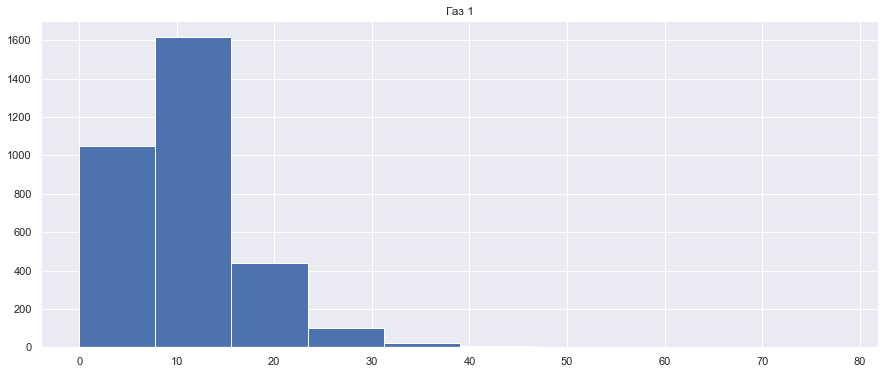

In [9]:
data_gas.hist(figsize=(15, 6));

В таблице `data_gas - данные о продувке сплава газом`:
- нет пропусков и нет дубликатов;
- переименуем столбцы на латиницу и в формат snake_case.

In [10]:
start(data_temp)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18092 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Время замера  18092 non-null  object 
 1   Температура   14665 non-null  float64
dtypes: float64(1), object(1)
memory usage: 424.0+ KB

         Температура
count  14665.000000
mean    1590.722741
std       20.394381
min     1191.000000
25%     1580.000000
50%     1590.000000
75%     1599.000000
max     1705.000000


,Время замера,Температура
key,,
312,2019-05-15 12:36:36,1604.0
952,2019-06-09 11:17:01,1594.0
2226,2019-07-31 15:10:53,1571.0
1498,2019-06-28 18:43:30,1561.0
2454,2019-08-08 22:47:29,1571.0


Количество пропусков в таблице: 3427 

Время замера       0
Температура     3427
dtype: int64 

Количество дубликатов в таблице: 0


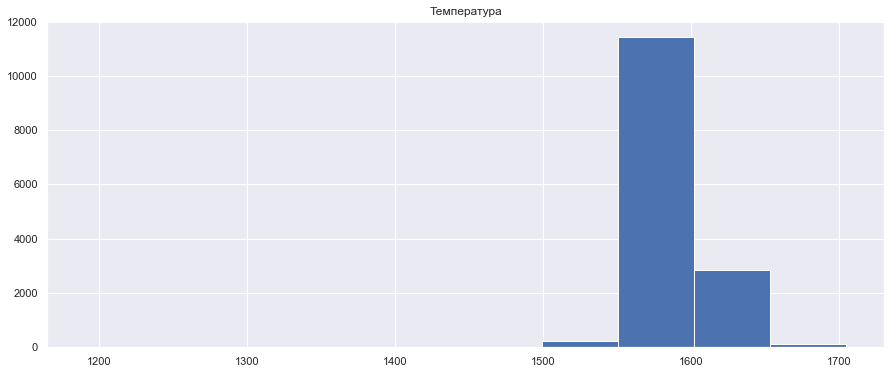

In [11]:
data_temp.hist(figsize=(15, 6));

В таблице `data_temp — результаты измерения температуры`:
- есть пропуски в таблице. Возможно они связаны с неисправностью датчика на оборудовании;
- `удалим всю партию`, если будет замечена температута `меньше 1500`. По информации от заказчика мы знаем, что эти данные не нужны;
- удалим партии, где был `только один замер температуры` за весь цикл; 
- выделим в отдельную таблицу начальную и конечную температуры, так же номер партии. К этой таблице будет присоединять другие по ключу; 
- поменяем формат данных если понадобится.

In [12]:
start(data_wire)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   float64
 2   Wire 3  63 non-null     float64
 3   Wire 4  14 non-null     float64
 4   Wire 5  1 non-null      float64
 5   Wire 6  73 non-null     float64
 6   Wire 7  11 non-null     float64
 7   Wire 8  19 non-null     float64
 8   Wire 9  29 non-null     float64
dtypes: float64(9)
memory usage: 240.7 KB

             Wire 1       Wire 2      Wire 3      Wire 4  Wire 5      Wire 6  \
count  3055.000000  1079.000000   63.000000   14.000000   1.000   73.000000   
mean    100.895853    50.577323  189.482681   57.442841  15.132   48.016974   
std      42.012518    39.320216   99.513444   28.824667     NaN   33.919845   
min       1.918800     0.030160    0.144144   24.148801  15.132    0.034320   
25%      72.115684    20.193680   95.135044   40

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1598,80.074799,25.726480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3048,60.059998,30.039358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
965,122.241600,195.225677,NaN,NaN,NaN,NaN,NaN,NaN,35.0168
2471,150.171829,102.182083,NaN,NaN,NaN,NaN,NaN,NaN,63.0448
1498,141.195602,35.106239,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество пропусков в таблице: 23385 

Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64 

Количество дубликатов в таблице: 403


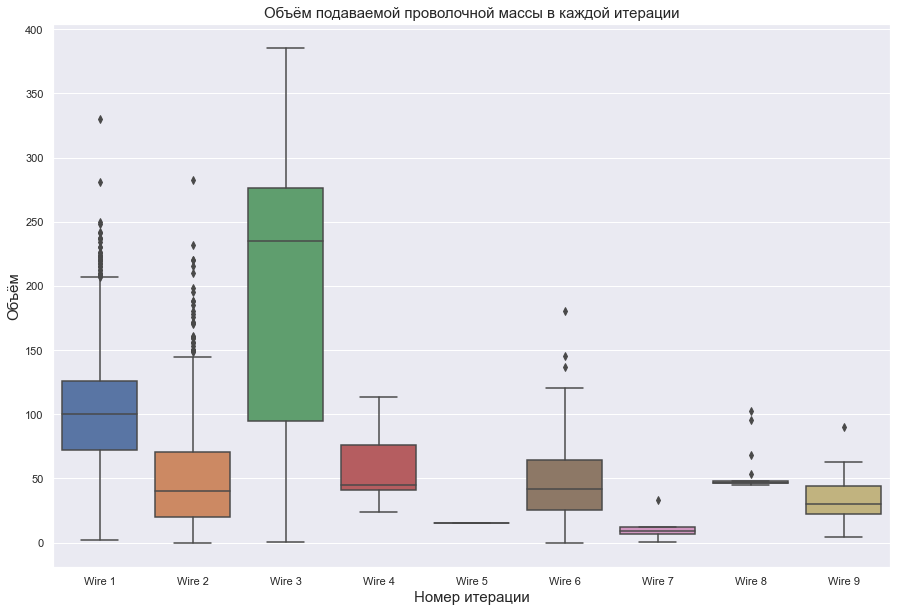

In [13]:
sns.boxplot(data=data_wire);
plt.title('Объём подаваемой проволочной массы в каждой итерации', fontsize=15);
plt.xlabel('Номер итерации', fontsize=15);
plt.ylabel('Объём', fontsize=15);

В таблице `data_wire — данные о проволочных материалах (объём)`:
- дубликатов нет, но есть много пропусков;
- заполним все пропуски значением `0 - не добавляли проволочные материалы в итерации`;
- переименуем столбцы в формат snake_case.

Таблицу `data_wire_time` мы рассматривать не будем, так как при обучении моделей не будем использовать временные данные.

***Вывод:*** Мы взглянули на данные каждой таблицы. Что будем делать:
- в `data_arc` удалим аномалии в `Реактивная мощность`. Все значения, что `меньше -100`. Тут же агрегируем данные по партии, ссумировав показатели;
- в `data_temp удалим всю партию`, если будет замечена температута `меньше 1500`. По информации от заказчика мы знаем, что эти данные не нужны. Так же удалим партии, где был `только один замер температуры` за весь цикл. Выделим в отдельную таблицу начальную и конечную температуры, так же номер партии. К этой таблице будет присоединять другие по ключу;
- в `data_wire и data_bulk` заполним все пропуски значением `0 - не добавляли материалы в итерации`;
- в `data_bulk` удалим выброс в трениновочной выборке;
- по возможности создадим новые признаки в таблицах; 
- переименуем столбцы в формат snake_case в итоговой таблице.

## Предобработка данных

Начинаем с `data_arc` и удаление аномалий в `Реактивная мощность`. Удалим все значения, что `меньше -100`.

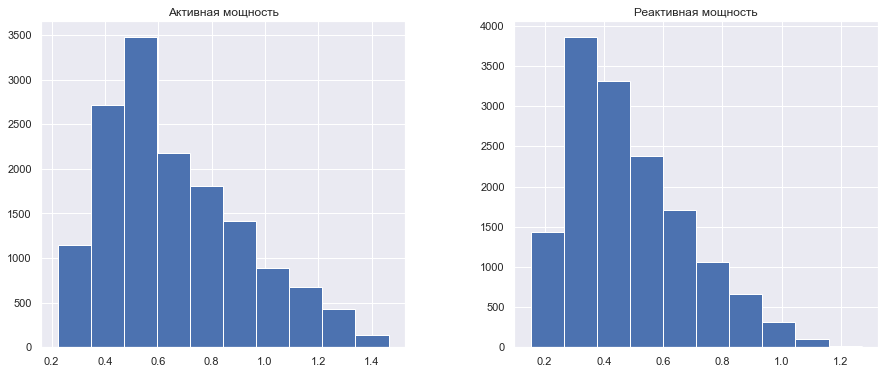

In [14]:
data_arc = data_arc[data_arc['Реактивная мощность'] >= -100]
data_arc.hist(figsize=(15, 6));

Отлично! Создадим новый признак на базе информации о времени нагрева и агрегируем данные по партии, ссумировав показатели.

In [15]:
# переведём в формат времени
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

# создадим столбец с новым признаком
data_arc['diff_seconds'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).astype('timedelta64[s]')
data_arc['diff_seconds'].head()

key
1    228.0
1    185.0
1    172.0
1    365.0
1    148.0
Name: diff_seconds, dtype: float64

In [16]:
data_arc = data_arc.groupby('key').agg({'Активная мощность': ['sum', 'mean'],
                                        'Реактивная мощность': ['sum', 'mean'], 
                                        'diff_seconds': ['sum', 'mean']})

data_arc.columns = ['sum_active_power',
                    'mean_active_power',
                    'sum_reactive_power', 
                    'mean_reactive_power',
                    'sum_diff_seconds',
                    'mean_diff_seconds']
data_arc.head()

,sum_active_power,mean_active_power,sum_reactive_power,mean_reactive_power,sum_diff_seconds,mean_diff_seconds
key,,,,,,
1,3.036730,0.607346,2.142821,0.428564,1098.0,219.60
2,2.139408,0.534852,1.453357,0.363339,811.0,202.75
3,4.063641,0.812728,2.937457,0.587491,655.0,131.00
4,2.706489,0.676622,2.056992,0.514248,741.0,185.25
5,2.252950,0.563238,1.687991,0.421998,869.0,217.25


Пререйдём к `data_wire и data_bulk`. Заполним все пропуски значением `0`.

In [17]:
data_wire = data_wire.fillna(0)
data_wire.isna().sum().sum()

0

In [18]:
data_bulk = data_bulk.fillna(0)
data_bulk.isna().sum().sum()

0

Далее в `data_temp` удалим всю партию, если будет замечена температура `меньше 1500`.

Количество строк в таблице: 18065


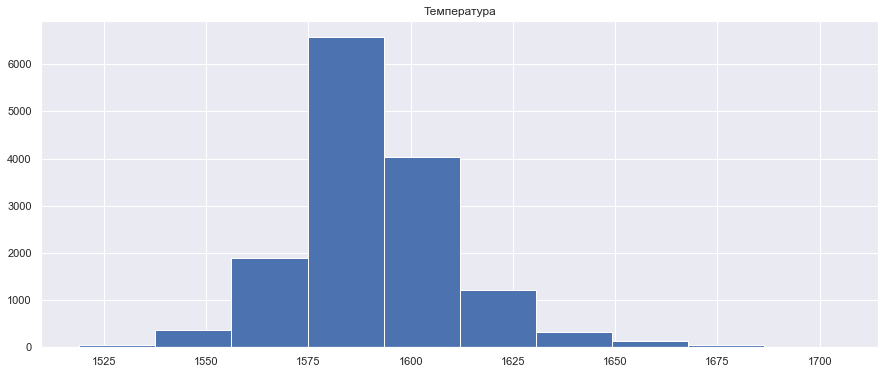

In [19]:
index_to_drop = data_temp.loc[data_temp['Температура'] < 1500].index
data_temp = data_temp.drop(index_to_drop)

print('Количество строк в таблице:', data_temp.shape[0])
data_temp.hist(figsize=(15, 6));

Хорошо. Так же удалим партии, где был только один замер температуры за весь цикл.

In [20]:
index_to_drop = data_temp.loc[data_temp.groupby('key')['Температура'].agg('count') <= 1].index
data_temp = data_temp.drop(index_to_drop)

print('Количество строк в таблице:', data_temp.shape[0])

Количество строк в таблице: 13903


Теперь выделим в отдельную таблицу начальную и конечную температуры, так же номер партии. К этой таблице будем в дальнейшем присоединять другие дынне по ключу.

In [21]:
data_all = data_temp.groupby('key').agg(min_temp=('Температура', 'first'),
                                        max_temp=('Температура', 'last'))
data_all.head()

,min_temp,max_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


И сразу проверим на пропуски полученую таблицу.

In [22]:
data_all.isna().sum()

min_temp    0
max_temp    0
dtype: int64

Создамим ещё `2 признака`, сумировав все добавлиния материалов.

In [23]:
data_bulk['sum_bulk'] = data_bulk.sum(axis=1)
data_wire['sum_wire'] = data_wire.sum(axis=1)
display(data_bulk.sample(3))
display(data_wire.sample(3))

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
key,,,,,,,,,,,,,,,,
2643,0.0,0.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,202.0,0.0,98.0,206.0,626.0
170,0.0,0.0,198.0,0.0,0.0,350.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,272.0,0.0,927.0
2999,0.0,0.0,50.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0,0.0,142.0,102.0,642.0


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,
2156,49.008961,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.008961
2309,95.047676,81.160561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,176.208237
1294,167.356796,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167.356796


Соединим данные и посмотрим на полученй датафрейм.

In [24]:
data_all = data_all.merge(data_bulk, on='key')
data_all = data_all.merge(data_arc, on='key')
data_all = data_all.merge(data_gas, on='key')
data_all = data_all.merge(data_wire, on='key')
data_all.sample(10)

,min_temp,max_temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,sum_active_power,mean_active_power,sum_reactive_power,mean_reactive_power,sum_diff_seconds,mean_diff_seconds,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1114,1623.0,1598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,253.0,0.0,121.0,203.0,577.0,1.113157,0.556579,0.816230,0.408115,288.0,144.000000,4.729161,65.005203,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.005203
2149,1574.0,1576.0,0.0,0.0,0.0,0.0,0.0,97.0,0.0,0.0,0.0,0.0,0.0,514.0,0.0,278.0,105.0,994.0,3.593026,0.718605,2.578833,0.515767,979.0,195.800000,17.662955,110.248314,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.248314
2007,1629.0,1590.0,0.0,0.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,0.0,108.0,206.0,655.0,2.669650,0.667412,2.006402,0.501601,613.0,153.250000,15.246359,123.133927,4.101760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.235687
2296,1585.0,1582.0,0.0,0.0,54.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,181.0,0.0,280.0,3.485588,0.871397,2.434975,0.608744,396.0,99.000000,15.256108,52.153916,48.165520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.319436
126,1592.0,1595.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,103.0,205.0,583.0,3.654703,0.730941,2.583751,0.516750,952.0,190.400000,7.836757,56.085118,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.085118
1019,1547.0,1600.0,0.0,0.0,154.0,0.0,0.0,234.0,0.0,0.0,0.0,0.0,106.0,138.0,0.0,201.0,102.0,935.0,3.738539,0.623090,2.733800,0.455633,1408.0,234.666667,14.834805,100.432801,50.125919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.558720
2223,1553.0,1594.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,69.0,226.0,0.0,129.0,227.0,678.0,1.854569,0.463642,1.349528,0.337382,986.0,246.500000,13.085626,25.989599,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.989599
24,1578.0,1585.0,0.0,0.0,89.0,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,412.0,0.0,204.0,203.0,1016.0,3.251568,0.541928,2.269395,0.378232,1187.0,197.833333,11.487776,101.730722,50.319363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.050085
2128,1587.0,1591.0,0.0,0.0,19.0,64.0,0.0,0.0,0.0,0.0,0.0,105.0,0.0,255.0,0.0,103.0,226.0,772.0,2.445903,0.611476,1.731027,0.432757,697.0,174.250000,22.356804,121.080955,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.080955


In [25]:
data_all

,min_temp,max_temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,sum_active_power,mean_active_power,sum_reactive_power,mean_reactive_power,sum_diff_seconds,mean_diff_seconds,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,3.036730,0.607346,2.142821,0.428564,1098.0,219.600000,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,2.139408,0.534852,1.453357,0.363339,811.0,202.750000,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,4.063641,0.812728,2.937457,0.587491,655.0,131.000000,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
4,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,2.706489,0.676622,2.056992,0.514248,741.0,185.250000,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
5,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,2.252950,0.563238,1.687991,0.421998,869.0,217.250000,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,719.0,3.168133,0.792033,2.210936,0.552734,723.0,180.750000,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.150879
2496,1554.0,1591.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,796.0,4.174918,0.695820,2.872031,0.478672,940.0,156.666667,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.179527
2497,1571.0,1589.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,665.0,3.605239,1.201746,2.452092,0.817364,569.0,189.666667,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.134723


Переименуем столбцы в получившейся таблице.

In [26]:
data_all.columns = ['min_temp', 'max_temp', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
                    'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 
                    'sum_bulk', 'sum_active_power', 'mean_active_power', 'sum_reactive_power', 
                    'mean_reactive_power', 'sum_diff_seconds', 'mean_diff_seconds', 'gas_1',
                    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
                    'sum_wire']
data_all.head(3)

,min_temp,max_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,sum_bulk,sum_active_power,mean_active_power,sum_reactive_power,mean_reactive_power,sum_diff_seconds,mean_diff_seconds,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,sum_wire
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,3.036730,0.607346,2.142821,0.428564,1098.0,219.60,29.749986,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
2,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,2.139408,0.534852,1.453357,0.363339,811.0,202.75,12.555561,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
3,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,4.063641,0.812728,2.937457,0.587491,655.0,131.00,28.554793,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.160157


Теперь сделаем разделение на обучающую и тестовую выборки. Размер тестовой выборки у нас будет `25%`.

In [27]:
features = data_all.drop('max_temp', axis=1)
target = data_all['max_temp']

In [28]:
features_train, features_test, target_train, target_test  = train_test_split(
    features, target, test_size=0.25, random_state=80523)

print(features_train.shape[0])
print(features_test.shape[0])

1743
582


***Вывод:*** В ходе этапа предобработки данных мы выполнили все намеченые пункты, что прописали при знакомстве с таблицами. Так же:
- создали новые признаки:
    - в `data_bulk, data_wire` = сумма значений добавляемых материалов;
    - в `data_temp` = начальная и конечная температура;
    - в `data_arc` = время нагрева, реактивная и активная мощность (сумма и среднее);
- разделили выборки на обучающую и тестовую;
- тестова выборка у нас `25%` от общей массы.

## Обучение моделей

Для обучения мы выберем `2 модели`. Одна классическая `DecisionTreeRegressor`, а вторая модель `CatBoostRegressor` (модель с технологией градиентного бустинга). Оптимальные параметры будем подбирать при помощи `GridSearchCV`.

Но для начала сделаем рассчёты показателей констатной модели.

In [29]:
predicted = pd.Series(target_train.mean(), target_train.index)
mae_final = mean_absolute_error(target_train, predicted)
print('Итоговый MAE константной модели:', mae_final)

Итоговый MAE константной модели: 8.060088563416851


И так первая модель `DecisionTreeRegressor`. Это древовидная форма модели, поэтому мультиколлениарность можно не учитывать.

In [30]:
%%time 
model = DecisionTreeRegressor(random_state=80523)

param_grid = {'max_depth': range (1, 10)}

grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

best_param_train_DTR = grid.best_params_
best_score_train_DTR = grid.best_score_

print('Параметры лучшей модели:', best_param_train_DTR)
print('МАЕ лучшей модели:', best_score_train_DTR)

Параметры лучшей модели: {'max_depth': 5}
МАЕ лучшей модели: -7.267031255960743
Wall time: 2.36 s


Вторая модель `CatBoostRegressor`.

In [31]:
%%time 
model = CatBoostRegressor(verbose=False, random_state=80523)


param_grid = {'depth': range (1, 10)}

grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

best_param_train_CBR = grid.best_params_
best_score_train_CBR = grid.best_score_

print('Параметры лучшей модели:', best_param_train_CBR)
print('MAE лучшей модели:', best_score_train_CBR)

Параметры лучшей модели: {'depth': 4}
MAE лучшей модели: -5.982883388138522
Wall time: 7min 56s


Лучше показала себя модель `CatBoostRegressor с параметрами 'depth': 4`. Проверим модель на тестовой выборке.

In [32]:
model = CatBoostRegressor(depth=4, verbose=False, random_state=80523)
model.fit(features_train, target_train)
predicted = model.predict(features_test)
mae_final = mean_absolute_error(target_test, predicted)
print('Итоговый MAE константной модели:', mae_final)

Итоговый MAE константной модели: 6.200086786306175


Теперь посмотрим какие из признаков больше влияют на предсказания модели.

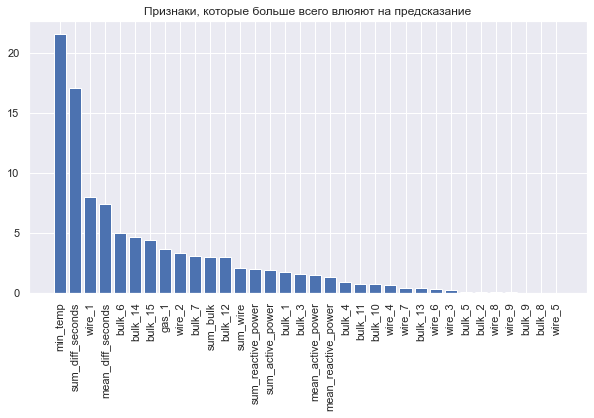

In [33]:
feature_importance = model.get_feature_importance()

# создадим DataFrame из вектора важности признаков
df = pd.DataFrame({'feature': features_train.columns, 'importance': feature_importance})

# отсортируем значения вектора по убыванию
df = df.sort_values('importance', ascending=False)

# построим график важности признаков
plt.figure(figsize=(10, 5))
plt.bar(df['feature'], df['importance'])
plt.xticks(rotation=90)
plt.title('Признаки, которые больше всего влюяют на предсказание')
plt.show()

Признаки, которые больше всего влияют на предсказания модели:
1. `min_temp` - начальная температура
2. `sum_diff_seconds` - суммарное время нагрева ёмкости с металлом (сек.)
3. `wire_1` - количество загружаемой проволки в ёмкость в перовй итерации цикла
4. `mean_diff_seconds` - среднее значение времени нагрева ёмкости с металлом (сек.)

***Вывод:*** Для обучения мы выбрали `2 модели`. Одна классическая `DecisionTreeRegressor`, а вторая модель `CatBoostRegressor` (с бустингом). Оптимальные параметры подбирали при помощи `GridSearchCV`. Под нашу задачу в итоге подошла модель `CatBoostRegressor с параметрами 'depth': 4`. На тестовой выборке результат `MAE 6.2`

Признаки, которые больше всего влияют на предсказания модели:
1. `min_temp` - начальная температура
2. `sum_diff_seconds` - суммарное время нагрева ёмкости с металлом (сек.)
3. `wire_1` - количество загружаемой проволки в ёмкость в перовй итерации цикла
4. `mean_diff_seconds` - среднее значение времени нагрева ёмкости с металлом (сек.)

## Общий вывод

Нам нужно было построить модель, которая предскажет конечную температуру стали. Тем самым оптимизировав работу  металлургического комбината. Мы использовали данные с разных источников. Вот что мы сделали в этапе для подготовки к обучению моделей:
- удалили аномалии в столбце `Реактивная мощность`. Все значения, что `меньше -100`. Тут же агрегировали данные по партии, ссумировав показатели;
- заполнили все пропуски  в таблицах `data_bulk и data_wire` значением `0 - не добавляли материалы в итерации`;
- удалили из таблицы `data_temp` все партию, если была замечена температура `меньше 1500` в каком-то из этапов цикла;
- так же удалили партии, где был только один замер температуры за весь цикл
- создали новые признаки:
    - в `data_bulk, data_wire` = сумма значений добавляемых материалов;
    - в `data_temp` = начальная и конечная температура;
    - в `data_arc` = время нагрева, реактивная и активная мощность (сумма и среднее);
- затем соединили данные в один датафрейм по общему ключу;
- переименовали столбцы в получившейся таблице; 				
- далее разделили выборки на обучающую и тестовую;
- тестова выборка у нас `25%` от общей массы.

Для обучения мы выбрали `2 модели`. Одна классическая `DecisionTreeRegressor`, а вторая модель `CatBoostRegressor` (с бустингом). Оптимальные параметры подбирали при помощи `GridSearchCV`. Под нашу задачу в итоге подошла модель `CatBoostRegressor с параметрами 'depth': 4`. На тестовой выборке результат `MAE 6.2`

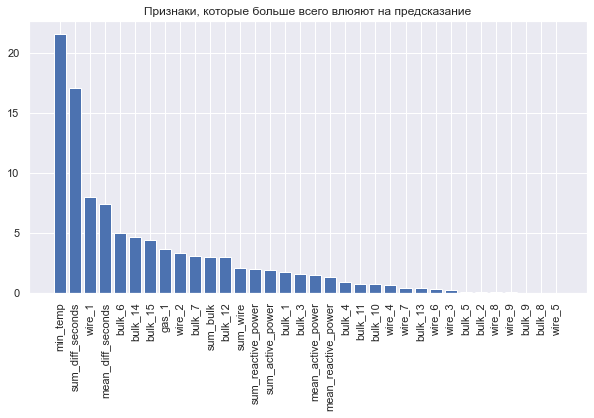

Признаки, которые больше всего влияют на предсказания модели:
1. `min_temp` - начальная температура
2. `sum_diff_seconds` - суммарное время нагрева ёмкости с металлом (сек.)
3. `wire_1` - количество загружаемой проволки в ёмкость в перовй итерации цикла
4. `mean_diff_seconds` - среднее значение времени нагрева ёмкости с металлом (сек.)